In [2]:
import pandas as pd
import numpy as np
import networkx as nx
from tqdm import tqdm
import os

In [3]:
integrate = pd.read_csv("../data/integrate.csv")
integrate.head(2)

,A,B
0,Q9H2S6,Q9NPE6
1,Q9H2S6,Q9BXK5


In [4]:
all_genes = list(set(integrate['A'].tolist()+integrate['B'].tolist()))
len(all_genes)

15939

In [ ]:
SAVE_ROOT = '/home/lyz/PhaSepGAT/saves/INTEGRATE_ProSE80d_pos1neg1/'
preds = pd.read_pickle(f'{SAVE_ROOT}preds.pkl')
genes = pd.read_pickle(f'{SAVE_ROOT}genes.pkl')

In [6]:
genename_to_uniprot = pd.read_pickle("../data/HUMAN_9606_idmapping_genename.pkl")
genename_to_uniprot_integrate = genename_to_uniprot.set_index(['Uniprot']).loc[list(set(genes)&set(genename_to_uniprot['Uniprot'].tolist())),:].reset_index()

genename_to_uniprot_dict = genename_to_uniprot_integrate.set_index(['ID']).to_dict()['Uniprot']
uniprot_to_genename_dict = genename_to_uniprot_integrate.set_index(['Uniprot']).to_dict()['ID']

In [7]:
llps_scores = pd.read_pickle("../data/HUMAN_9606_PhaSePred_SaPS_PdPS.pkl")
llps_dict = llps_scores.set_index(['entry']).to_dict()

In [ ]:
known_ps_protein = pd.read_pickle("/home/lyz/PhaSepGAT/data/Label/human.condensate-formation.proteins-v1.pkl")
known_ps_protein = known_ps_protein[known_ps_protein['source']=='literature']['uniprot_entry'].tolist()

In [7]:
import json

In [52]:
with open("../data/cophase_data.json",'r') as f:
    co_phase_data_dict = json.load(f)

## Deleting existed PPIs in Integreted Human PPI Network

In [69]:
data_files = os.listdir("./promixity")
len(data_files)

220

In [70]:
all_summary = []

In [71]:
for k in tqdm(range(len(data_files))):
    f = data_files[k]
    data = pd.read_csv(f"./promixity/{f}")
    
    bait = data.loc[0,'Bait_uniprot']
    bait_g = data.loc[0,'Bait Gene']
    
    if bait in all_genes:
        preys = data['Prey_uniprot'].tolist()
        preys_in_net = list(set(preys)&set(integrate['A'].tolist()+integrate['B'].tolist()))

        edges_integrate = pd.concat([integrate[integrate['A']==bait], integrate[integrate['B']==bait]])
        edges_partners = list(set(edges_integrate['A'].tolist()) | set(edges_integrate['B'].tolist()))

        partners_not_in_net = [i for i in preys_in_net if i not in edges_partners]
        partners_not_in_net = [i for i in partners_not_in_net if i != bait]

        data_filtered = pd.DataFrame(index=range(len(partners_not_in_net)))
        data_filtered['Bait Gene'] = [bait_g]*len(data_filtered)
        data_filtered['Bait_uniprot'] = [bait]*len(data_filtered)
        data_filtered['Prey_uniprot'] = partners_not_in_net
        data_filtered['article'] = [f[:-4].split('_')[0]]*len(data_filtered)
        data_filtered['Prey Gene'] = data_filtered['Prey_uniprot'].map(uniprot_to_genename_dict)
        data_filtered['Bait_SaPS-10fea'] = data_filtered['Bait_uniprot'].map(llps_dict['SaPS-10fea'])
        data_filtered['Bait_PdPS-10fea'] = data_filtered['Bait_uniprot'].map(llps_dict['PdPS-10fea'])
        data_filtered['Prey_SaPS-10fea'] = data_filtered['Prey_uniprot'].map(llps_dict['SaPS-10fea'])
        data_filtered['Prey_PdPS-10fea'] = data_filtered['Prey_uniprot'].map(llps_dict['PdPS-10fea'])
        
        data_filtered = data_filtered.dropna(subset=['Prey_SaPS-10fea'])

        cossim_list = []
        for p in partners_not_in_net:
            try:
                cossim_list.append(co_phase_data_dict[bait+p])
            except:
                cossim_list.append(co_phase_data_dict[p+bait])
        data_filtered['cos.sim'] = cossim_list

        data_filtered.to_csv(f'./promixity_filtered/{f}',index=False)
        if bait == 'Q01130':
            print(k)
        all_summary.append([bait_g, bait, len(preys),len(preys_in_net),len(partners_not_in_net),f[:-4].split('_')[0]])

100%|██████████| 220/220 [00:34<00:00,  6.45it/s]

219


In [72]:
all_summary = pd.DataFrame(all_summary,columns=['Gene','Uniprot','Preys','Preys in net','Preys not in edges','PMID'])

In [73]:
all_summary[all_summary['Uniprot']=='Q01130']

,Gene,Uniprot,Preys,Preys in net,Preys not in edges,PMID
215,SC35,Q01130,2527,2520,2497,32609799


In [75]:
all_summary['Bait_SaPS-10fea'] = all_summary['Uniprot'].map(llps_dict['SaPS-10fea'])
all_summary['Bait_PdPS-10fea'] = all_summary['Uniprot'].map(llps_dict['PdPS-10fea'])

In [76]:
all_summary.to_csv("promixity_summary_all.csv",index=False)

## For one protein, comparing with background

In [9]:
llps_proteins_list = ['Q01130','Q13283','O15055','P00533','Q9BPZ3']

In [10]:
backgrounds_all = pd.DataFrame()
real_all =[]

In [11]:
for p in llps_proteins_list:
    background_distribution1 = pd.read_csv(f"./background/{p}.csv")
    real_values1 = pd.read_csv(f"./promixity_combined/{p}.csv")

    background_distribution1 = background_distribution1.loc[:,['mean_cossim']]
    background_distribution1['class'] = [p]*len(background_distribution1)
    backgrounds_all = pd.concat([backgrounds_all,background_distribution1])
    real_all.append(np.mean(real_values1['cos.sim'].tolist()))


In [12]:
backgrounds_all

,mean_cossim,class
0,0.410920,Q01130
1,0.410968,Q01130
2,0.412679,Q01130
3,0.413910,Q01130
4,0.417487,Q01130
...,...,...
995,0.172423,Q9BPZ3
996,0.174756,Q9BPZ3
997,0.152141,Q9BPZ3
998,0.154382,Q9BPZ3


In [13]:
import matplotlib.pyplot as plt  
%matplotlib inline
%config InlineBackend.figure_format = 'jpg'
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

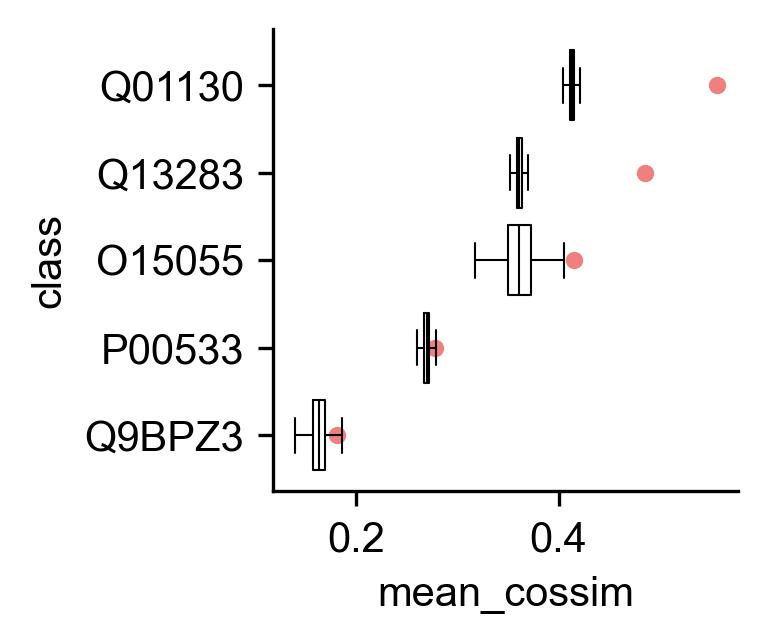

In [14]:
fig = plt.subplots(figsize=(2,2),dpi=300) 
sns.set_style('white')


sns.boxplot(data=backgrounds_all,x='mean_cossim',y='class',showfliers=False,color='black',fill=False,linewidth=0.5)

for i in range(5):
    plt.scatter(y=i,x=real_all[i],s=10,color='lightcoral')


sns.despine()

plt.savefig(f"./Fig3B.png",bbox_inches = 'tight',dpi=300)

## Comparing cisine similarity with random background

In [98]:
data_files = os.listdir("./promixity_filtered")
len(data_files)

216

In [99]:
data_files[0]

'17289661_Q9NZI8.csv'

In [79]:
import random
import scipy.stats as stats

In [80]:
for k in tqdm(range(len(data_files))):
    f = data_files[k]
    data = pd.read_csv(f"./promixity_filtered/{f}")
    
    
    bait = data.loc[0,'Bait_uniprot']
    bait_g = data.loc[0,'Bait Gene']
    bait_saps = data.loc[0,'Bait_SaPS-10fea']
    bait_pdps = data.loc[0,'Bait_PdPS-10fea']
    
    bait_data = [i for i in list(co_phase_data_dict.keys()) if bait in i]
    bait_cossim = [co_phase_data_dict[i] for i in bait_data]
    bait_with_cossim = pd.DataFrame(index=range(len(bait_data)))
    bait_with_cossim['Prey_uniprot'] = bait_data
    bait_with_cossim['cossim'] = bait_cossim
    bait_with_cossim.to_csv(f"./all_partners_cossim/{bait}.csv")
    

100%|██████████| 216/216 [25:50<00:00,  7.18s/it]


In [ ]:
# 合并相同蛋白

In [82]:
len(os.listdir(f"./all_partners_cossim/"))

203

In [140]:
all_uniprot = []
for i in data_files:
    all_uniprot.append(i[1:].split('.')[0].split('_')[1])
all_uniprot = np.unique(all_uniprot).tolist()
len(all_uniprot)

370

In [141]:
data_summary = []

In [142]:
for p in tqdm(all_uniprot):
    this_p_file = [i for i in data_files if p in i]
    
    pmid = ''
    
    this_p_data_all = pd.DataFrame()
    for pf in this_p_file:
        #data_pf = pd.read_csv('./promixity_filtered/'+pf)
        data_pf = pd.read_csv(pf)
        this_p_data_all = pd.concat([this_p_data_all,data_pf])
        pmid+=pf.split('/')[2].split('_')[0]+', '
        #pmid+=pf.split('_')[0]+', '
        
    this_p_data_all = this_p_data_all.drop_duplicates(subset=['Prey_uniprot'])
    this_p_data_all.to_csv(f"./promixity_combined/{p}.csv")
    
    data_summary.append([p,len(this_p_data_all),pmid[:-2]])

100%|██████████| 370/370 [00:46<00:00,  7.98it/s]


In [113]:
data_summary_df = pd.DataFrame(data_summary,columns = ['uniprot','Num_preys','PMID'])
data_summary_df['SaPS-10fea'] = data_summary_df['uniprot'].map(llps_dict['SaPS-10fea'])
data_summary_df['PdPS-10fea'] = data_summary_df['uniprot'].map(llps_dict['PdPS-10fea'])
data_summary_df['SaPS-8fea'] = data_summary_df['uniprot'].map(llps_dict['SaPS-8fea'])
data_summary_df['PdPS-8fea'] = data_summary_df['uniprot'].map(llps_dict['PdPS-8fea'])

In [114]:
data_summary_df

,uniprot,Num_preys,PMID,SaPS-10fea,PdPS-10fea,SaPS-8fea,PdPS-8fea
0,A0AV96,146,29395067,0.329001,0.257143,0.335920,0.367314
1,A0FGR8,149,37931956,0.421148,0.709921,0.075430,0.336415
2,A5YKK6,8,29395067,0.167426,0.152646,0.536207,0.404258
3,O00178,26,29395067,0.713772,0.446460,0.269502,0.484926
4,O00244,49,34550632,0.173481,0.399118,0.072456,0.433647
...,...,...,...,...,...,...,...
198,Q9Y3F4,7,29395067,0.288940,0.477604,0.062340,0.162144
199,Q9Y4F3,51,29395067,0.109177,0.290736,0.161058,0.574381
200,Q9Y4Z0,52,29395067,0.093078,0.261316,0.560568,0.396553
201,Q9Y5A9,125,29395067,0.942175,0.901862,0.938018,0.812827


In [116]:
data_summary_df.to_csv("Proximity_combined.csv",index=None)

In [115]:
len(os.listdir(f"./promixity_combined/"))

203

In [120]:
data_files = os.listdir(f"./promixity_combined/")

In [121]:
all_bait_compare_summary = []

In [122]:
for k in tqdm(range(len(data_files))):
    f = data_files[k]
    data = pd.read_csv(f"./promixity_combined/{f}")

    data = data.drop_duplicates(subset=['Prey_uniprot'])
    
    bait = data.loc[0,'Bait_uniprot']
    bait_g = data.loc[0,'Bait Gene']
    bait_saps = data.loc[0,'Bait_SaPS-10fea']
    bait_pdps = data.loc[0,'Bait_PdPS-10fea']
    #articles = ','.join([str(i) for i in data.drop_duplicates(subset=['article'])['article'].tolist()])
    
    cossim = data['cos.sim'].tolist()

    bait_with_cossim = pd.read_csv(f"./all_partners_cossim/{bait}.csv")
    
    
    
    background_list = []
    for m in range(1000):
        random_background = bait_with_cossim.sample(n=len(data),random_state=m)
        random_cossim = random_background['cossim'].tolist()
        pv = stats.mannwhitneyu(cossim,random_cossim,alternative='greater')[1]
        mean_cossim = np.mean(random_cossim)
        background_list.append([','.join(random_background['Prey_uniprot'].tolist()),','.join([str(i) for i in random_cossim]),mean_cossim,pv])
    
    background_df = pd.DataFrame(background_list,columns=['protein_list','cos.sim','mean_cossim','pv'])
    background_df.to_csv(f"./background/{bait}.csv")
    
    zscore = (np.mean(cossim)-np.mean(background_df['mean_cossim'].tolist()))/np.std(background_df['mean_cossim'].tolist())
    
    all_bait_compare_summary.append([bait,bait_g,bait_saps,bait_pdps,len(data),np.mean(background_df['pv'].tolist()),zscore])


100%|██████████| 203/203 [31:30<00:00,  9.31s/it]


In [123]:
pmid_df = []

In [124]:
for k in tqdm(range(len(data_files))):
    f = data_files[k]
    data = pd.read_csv(f"./promixity_combined/{f}")
    data = data.drop_duplicates(subset=['Prey_uniprot'])
    
    bait = data.loc[0,'Bait_uniprot']
    bait_g = data.loc[0,'Bait Gene']
    bait_saps = data.loc[0,'Bait_SaPS-10fea']
    bait_pdps = data.loc[0,'Bait_PdPS-10fea']
    pmids = ', '.join([str(i) for i in data.drop_duplicates(subset=['article'],keep='first')['article'].tolist()])
    


    pmid_df.append([bait,bait_g,bait_saps,pmids])


100%|██████████| 203/203 [00:00<00:00, 353.18it/s]


In [125]:
pmid_df = pd.DataFrame(pmid_df,columns=['Gene','Uniprot','SaPS','article'])

In [126]:
pmid_df.to_csv("tmp.csv")

In [127]:
all_bait_compare_summary_df = pd.DataFrame(all_bait_compare_summary,columns=['Gene','Uniprot','SaPS','PdPS','num_Preys','mean_pv','zscore'])

In [128]:
all_bait_compare_summary_df = all_bait_compare_summary_df.drop_duplicates(subset=['Gene'])

In [129]:
all_bait_compare_summary_df

,Gene,Uniprot,SaPS,PdPS,num_Preys,mean_pv,zscore
0,Q9NZI8,IMP1,0.525629,0.795508,113,8.214131e-22,18.011417
1,Q9NX05,FAM120C,0.231581,0.102665,225,6.738799e-16,14.064514
2,P60842,eIF4A1,0.163013,0.365248,58,2.504988e-08,9.527152
3,Q9H074,PAIP1,0.605274,0.589198,28,2.910619e-04,6.222006
4,Q9H7E2,TDRD3,0.897540,0.883250,135,3.364009e-18,14.750538
...,...,...,...,...,...,...,...
198,Q6TCH7,PAQR3,0.085218,0.067076,988,9.486375e-01,-3.963986
199,Q13283,G3BP1,0.929826,0.575079,2353,1.021667e-97,34.470688
200,P01116,KRAS,0.583972,0.842191,1549,2.560274e-61,25.772949
201,Q8N884,cGAS,0.657121,0.932160,15,1.163667e-02,3.846812


In [130]:
all_bait_compare_summary_df[all_bait_compare_summary_df['Uniprot']=='SC35']

,Gene,Uniprot,SaPS,PdPS,num_Preys,mean_pv,zscore
189,Q01130,SC35,0.906741,0.957755,2497,4.682668e-162,43.563056


In [135]:
filelist = os.listdir("./promixity_combined")

In [136]:
len(filelist)

203

In [133]:
all_interactom = pd.DataFrame()

In [137]:
for f in filelist:
    data = pd.read_csv(f"./promixity_combined/{f}")
    all_interactom = pd.concat([all_interactom,data])

In [138]:
all_interactom.to_csv("./all_promixity_data_combined.csv")

In [131]:
all_bait_compare_summary_df[all_bait_compare_summary_df['Uniprot']=='SC35']

,Gene,Uniprot,SaPS,PdPS,num_Preys,mean_pv,zscore
189,Q01130,SC35,0.906741,0.957755,2497,4.682668e-162,43.563056


In [132]:
all_bait_compare_summary_df.to_csv("./pv_zscore_filtered.csv",index=False)

In [17]:
all_bait_compare_summary_df = pd.read_csv("./pv_zscore_filtered.csv").sort_values(by=['num_Preys'],ascending=False)
all_bait_compare_summary_df.head(1)

,Uniprot,Gene,SaPS,PdPS,num_Preys,mean_pv,zscore,article
202,P49450,CENPA,0.445705,0.645103,2636,1.820000e-124,37.808632,32609799


In [18]:
known_ps_dict = dict(zip(known_ps_protein,['Known_PS']*len(known_ps_protein)))

In [19]:
all_bait_compare_summary_df['PreviousResearch'] = all_bait_compare_summary_df['Uniprot'].map(known_ps_dict)

In [20]:
len(all_bait_compare_summary_df)

203

In [21]:
all_ar = []
for i in all_bait_compare_summary_df['article'].tolist():
    all_ar += i.split(', ')
len(np.unique(all_ar))

62

In [22]:
all_bait_compare_summary_df = all_bait_compare_summary_df[all_bait_compare_summary_df['num_Preys']>=50]
len(all_bait_compare_summary_df)

149

In [23]:
all_bait_compare_summary_df

,Uniprot,Gene,SaPS,PdPS,num_Preys,mean_pv,zscore,article,PreviousResearch
202,P49450,CENPA,0.445705,0.645103,2636,1.820000e-124,37.808632,32609799,NaN
189,Q01130,SC35,0.906741,0.957755,2497,4.680000e-162,43.563056,32609799,Known_PS
199,Q13283,G3BP1,0.929826,0.575079,2353,1.020000e-97,34.470688,"29395067, 29373831, 33217318, 37119817",Known_PS
192,P22001,Kv1.3,0.135757,0.101213,1769,1.000000e+00,-14.125915,38936775,NaN
197,P00533,EGFR,0.752162,0.866251,1761,4.258136e-02,2.297141,35705039,NaN
...,...,...,...,...,...,...,...,...,...
135,Q9Y3A3,MOB4,0.059673,0.097963,53,1.374380e-04,6.264484,37536630,NaN
107,Q9Y4Z0,LSM4,0.093078,0.261316,52,7.750000e-11,11.908304,29395067,Known_PS
9,Q9NZB2,FAM120A,0.850118,0.858693,51,4.770000e-06,7.649928,29395067,NaN
106,Q9Y4F3,MARF1,0.109177,0.290736,51,2.020000e-07,8.075749,29395067,NaN


In [24]:
all_bait_compare_summary_df[all_bait_compare_summary_df['mean_pv']>0.05]

,Uniprot,Gene,SaPS,PdPS,num_Preys,mean_pv,zscore,article,PreviousResearch
192,P22001,Kv1.3,0.135757,0.101213,1769,1.000000,-14.125915,38936775,NaN
198,Q6TCH7,PAQR3,0.085218,0.067076,988,0.948637,-3.963986,30466064,NaN
161,P28328,PEX2,0.096385,0.061623,230,0.455296,-0.916685,35523862,NaN
159,Q9NX09,DDIT4,0.118733,0.059997,104,0.501532,0.520415,35563580,NaN
179,Q15262,PTPRK,0.113755,0.224419,72,0.390954,0.182922,30924770,NaN
81,Q9BPZ3,PAIP2,0.212680,0.540822,59,0.090310,2.108847,29395067,NaN


In [25]:
all_ar = []
for i in all_bait_compare_summary_df['article'].tolist():
    all_ar += i.split(', ')

In [26]:
len(np.unique(all_ar))

55

In [29]:
all_bait_compare_summary_df['class_PS'] = ['High-PS' if all_bait_compare_summary_df.loc[i,'SaPS'] > 0.5 or all_bait_compare_summary_df.loc[i,'PdPS'] > 0.5 or all_bait_compare_summary_df.loc[i,'PreviousResearch'] == 'Known_PS' else 'Low-PS' for i in all_bait_compare_summary_df.index]

In [30]:
all_bait_compare_summary_df

,Uniprot,Gene,SaPS,PdPS,num_Preys,mean_pv,zscore,article,PreviousResearch,class_PS
202,P49450,CENPA,0.445705,0.645103,2636,1.820000e-124,37.808632,32609799,NaN,High-PS
189,Q01130,SC35,0.906741,0.957755,2497,4.680000e-162,43.563056,32609799,Known_PS,High-PS
199,Q13283,G3BP1,0.929826,0.575079,2353,1.020000e-97,34.470688,"29395067, 29373831, 33217318, 37119817",Known_PS,High-PS
192,P22001,Kv1.3,0.135757,0.101213,1769,1.000000e+00,-14.125915,38936775,NaN,Low-PS
197,P00533,EGFR,0.752162,0.866251,1761,4.258136e-02,2.297141,35705039,NaN,High-PS
...,...,...,...,...,...,...,...,...,...,...
135,Q9Y3A3,MOB4,0.059673,0.097963,53,1.374380e-04,6.264484,37536630,NaN,Low-PS
107,Q9Y4Z0,LSM4,0.093078,0.261316,52,7.750000e-11,11.908304,29395067,Known_PS,High-PS
9,Q9NZB2,FAM120A,0.850118,0.858693,51,4.770000e-06,7.649928,29395067,NaN,High-PS
106,Q9Y4F3,MARF1,0.109177,0.290736,51,2.020000e-07,8.075749,29395067,NaN,Low-PS


In [18]:
all_bait_compare_summary_df['-log10(pv)'] = -np.log10(all_bait_compare_summary_df['mean_pv'].tolist())

In [33]:
import scipy.stats as stats

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

In [34]:
len(all_bait_compare_summary_df[all_bait_compare_summary_df['class_PS']=='High-PS'])

104

In [35]:
len(all_bait_compare_summary_df[all_bait_compare_summary_df['class_PS']=='Low-PS'])

45

In [ ]:
#all_bait_compare_summary_df.to_csv("./pv_zscore_filtered.csv",index=None)

In [15]:
all_bait_compare_summary_df = pd.read_csv("./pv_zscore_filtered.csv")

In [17]:
all_bait_compare_summary_df

,Uniprot,Gene,SaPS,PdPS,num_Preys,mean_pv,zscore,article,PreviousResearch,class_PS,#VALUE!
0,Q01130,SC35,0.906741,0.957755,2497,4.680000e-162,43.563056,32609799,Known_PS,High-PS,161.329754
1,P49450,CENPA,0.445705,0.645103,2636,1.820000e-124,37.808632,32609799,NaN,High-PS,123.739929
2,Q15287,RNPS1,0.874299,0.890033,759,7.590000e-105,35.449129,35640609,NaN,High-PS,104.119758
3,Q13283,G3BP1,0.929826,0.575079,2353,1.020000e-97,34.470688,"29395067, 29373831, 33217318, 37119817",Known_PS,High-PS,96.991400
4,Q13501,SQSTM1,0.744216,0.938113,1391,1.870000e-72,26.874620,38014048,Known_PS,High-PS,71.728158
...,...,...,...,...,...,...,...,...,...,...,...
144,Q15262,PTPRK,0.113755,0.224419,72,3.909538e-01,0.182922,30924770,NaN,Low-PS,0.407875
145,P28328,PEX2,0.096385,0.061623,230,4.552958e-01,-0.916685,35523862,NaN,Low-PS,0.341706
146,Q9NX09,DDIT4,0.118733,0.059997,104,5.015319e-01,0.520415,35563580,NaN,Low-PS,0.299701
147,Q6TCH7,PAQR3,0.085218,0.067076,988,9.486375e-01,-3.963986,30466064,NaN,Low-PS,0.022900


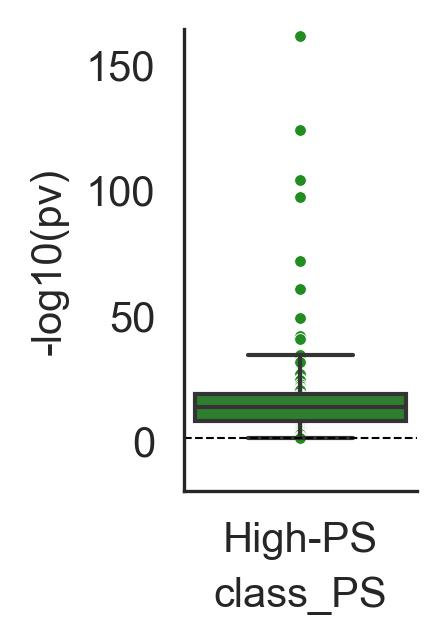

In [ ]:
fig = plt.subplots(figsize=(1,2),dpi=300) 
sns.set_style('white')

sns.boxplot(all_bait_compare_summary_df[all_bait_compare_summary_df['class_PS']=='High-PS'],x='class_PS',y='-log10(pv)',color='forestgreen',showfliers=False)
sns.scatterplot(all_bait_compare_summary_df[all_bait_compare_summary_df['class_PS']=='High-PS'],x='class_PS',y='-log10(pv)',color='forestgreen',s=8)


plt.axhline(y=-np.log10(0.05), color='black', linestyle='dashed',linewidth=0.5)
sns.despine()

plt.ylim([-20,164])


## GSEA of cosine similarity ~ GO function

In [61]:
import gseapy as gp

In [119]:
plot_proteins = ['Q01130','P49450','Q15287','Q13283','Q13501']

In [120]:
all_show_go = pd.DataFrame()

In [121]:
all_go_results = {}

In [203]:
for p in plot_proteins:
    data = pd.read_csv(f"./promixity_combined/{p}.csv")

    rnk = data.loc[:,['Prey Gene','cos.sim']].sort_values(by=['cos.sim'],ascending=False).drop_duplicates(subset=['Prey Gene'])
    rnk.columns=[0,1]
    rnk = rnk.set_index([0])
    
    pre_res = gp.prerank(rnk=rnk, # or rnk = rnk,
                     gene_sets=['GO_Biological_Process_2023','GO_Cellular_Component_2023', 'GO_Molecular_Function_2023'],
                     min_size=5,
                     max_size=1000,
                     permutation_num=1000, # reduce number to speed up testing
                     outdir=None, # don't write to disk
                     seed=6,
                     verbose=True, # see what's going on behind the scenes
                    )
    enrich_term = pre_res.res2d

    terms = enrich_term[(enrich_term['NES']>0)].sort_values(by=['FDR q-val'],ascending=True).iloc[:10,:]['Term'].tolist()
    single_plt = pre_res.plot(terms=terms[:10],
                   #legend_kws={'loc': (1.2, 0)}, # set the legend loc
                   show_ranking=True, # whether to show the second yaxis
                   figsize=(3,4),
                   ofname=f"./FigS3C_{p}.png"
                  )

    top_term = enrich_term[(enrich_term['NES']>0)].sort_values(by=['FDR q-val'],ascending=True).iloc[:10,:]
    top_term.loc[top_term.index,'protein'] = p

    all_show_go = pd.concat([all_show_go,top_term])

    tmp_dict = {}
    for t in top_term['Term'].tolist():
        tmp_dict[t] = pre_res.results[t]
    
    all_go_results[p] = tmp_dict


2024-11-03 19:11:36,927 [WARNING] Duplicated values found in preranked stats: 0.20% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-11-03 19:11:36,928 [INFO] Parsing data files for GSEA.............................
2024-11-03 19:11:36,928 [INFO] Enrichr library gene sets already downloaded in: C:\Users\wqswx\.cache/gseapy, use local file
2024-11-03 19:11:36,972 [INFO] Enrichr library gene sets already downloaded in: C:\Users\wqswx\.cache/gseapy, use local file
2024-11-03 19:11:36,983 [INFO] Enrichr library gene sets already downloaded in: C:\Users\wqswx\.cache/gseapy, use local file
2024-11-03 19:11:37,038 [INFO] 4799 gene_sets have been filtered out when max_size=1000 and min_size=5
2024-11-03 19:11:37,038 [INFO] 2229 gene_sets used for further statistical testing.....
2024-11-03 19:11:37,039 [INFO] Start to run GSEA...Might take a while..................
2024-11-03 19:11:46,267 [INFO] Congratulations. GSEApy runs successfully...........

In [ ]:
#all_show_go.to_csv("GSEA_fig3.csv",index=None)

In [125]:
all_show_go[all_show_go['protein']=='Q01130']['Term'].tolist()

['GO_Molecular_Function_2023__RNA Binding (GO:0003723)',
 'GO_Biological_Process_2023__Chromatin Remodeling (GO:0006338)',
 "GO_Molecular_Function_2023__mRNA 3'-UTR Binding (GO:0003730)",
 'GO_Biological_Process_2023__RNA Splicing (GO:0008380)',
 'GO_Biological_Process_2023__Cytoplasmic Translation (GO:0002181)',
 'GO_Biological_Process_2023__Gene Expression (GO:0010467)',
 'GO_Biological_Process_2023__Chromatin Organization (GO:0006325)',
 'GO_Molecular_Function_2023__snRNA Binding (GO:0017069)',
 'GO_Biological_Process_2023__Negative Regulation Of mRNA Catabolic Process (GO:1902373)',
 'GO_Cellular_Component_2023__Cytosolic Large Ribosomal Subunit (GO:0022625)']

In [123]:
all_show_go[all_show_go['protein']=='P49450']['Term'].tolist()

['GO_Molecular_Function_2023__RNA Binding (GO:0003723)',
 'GO_Biological_Process_2023__protein-RNA Complex Assembly (GO:0022618)',
 'GO_Biological_Process_2023__Translation (GO:0006412)',
 'GO_Cellular_Component_2023__Small-Subunit Processome (GO:0032040)',
 'GO_Cellular_Component_2023__U2-type Catalytic Step 2 Spliceosome (GO:0071007)',
 'GO_Biological_Process_2023__Maturation Of SSU-rRNA (GO:0030490)',
 'GO_Biological_Process_2023__RNA Stabilization (GO:0043489)',
 'GO_Biological_Process_2023__RNA Processing (GO:0006396)',
 'GO_Biological_Process_2023__rRNA Processing (GO:0006364)',
 'GO_Biological_Process_2023__Chromatin Remodeling (GO:0006338)']

In [124]:
all_show_go[all_show_go['protein']=='Q15287']['Term'].tolist()

['GO_Molecular_Function_2023__RNA Binding (GO:0003723)',
 'GO_Biological_Process_2023__Regulation Of mRNA Splicing, Via Spliceosome (GO:0048024)',
 'GO_Cellular_Component_2023__Nucleolus (GO:0005730)',
 'GO_Cellular_Component_2023__Nuclear Lumen (GO:0031981)',
 'GO_Molecular_Function_2023__snRNA Binding (GO:0017069)',
 'GO_Biological_Process_2023__Ribosomal Large Subunit Biogenesis (GO:0042273)',
 'GO_Molecular_Function_2023__mRNA Binding (GO:0003729)',
 'GO_Biological_Process_2023__Ribosome Biogenesis (GO:0042254)',
 'GO_Biological_Process_2023__mRNA Splicing, Via Spliceosome (GO:0000398)',
 'GO_Cellular_Component_2023__U2 snRNP (GO:0005686)']

In [126]:
all_show_go[all_show_go['protein']=='Q13283']['Term'].tolist()

['GO_Biological_Process_2023__Regulation Of mRNA Splicing, Via Spliceosome (GO:0048024)',
 'GO_Biological_Process_2023__Regulation Of Cytoplasmic Translation (GO:2000765)',
 'GO_Cellular_Component_2023__Cytoplasmic Stress Granule (GO:0010494)',
 'GO_Molecular_Function_2023__miRNA Binding (GO:0035198)',
 'GO_Molecular_Function_2023__Single-Stranded RNA Binding (GO:0003727)',
 'GO_Cellular_Component_2023__Nucleolus (GO:0005730)',
 'GO_Molecular_Function_2023__pre-mRNA Binding (GO:0036002)',
 'GO_Molecular_Function_2023__Regulatory RNA Binding (GO:0061980)',
 'GO_Biological_Process_2023__RNA Metabolic Process (GO:0016070)',
 'GO_Biological_Process_2023__Ribonucleoprotein Complex Biogenesis (GO:0022613)']

In [127]:
all_show_go[all_show_go['protein']=='Q13501']['Term'].tolist()

['GO_Cellular_Component_2023__U2 snRNP (GO:0005686)',
 'GO_Biological_Process_2023__U2-type Prespliceosome Assembly (GO:1903241)',
 'GO_Molecular_Function_2023__RNA Binding (GO:0003723)',
 'GO_Cellular_Component_2023__Spliceosomal snRNP Complex (GO:0097525)',
 'GO_Biological_Process_2023__RNA Processing (GO:0006396)',
 'GO_Biological_Process_2023__Chromatin Organization (GO:0006325)',
 'GO_Biological_Process_2023__Chromatin Remodeling (GO:0006338)',
 'GO_Cellular_Component_2023__U12-type Spliceosomal Complex (GO:0005689)',
 'GO_Biological_Process_2023__Histone Modification (GO:0016570)',
 'GO_Biological_Process_2023__Positive Regulation Of DNA-templated Transcription (GO:0045893)']

In [128]:
plot_term = {'Q01130':'GO_Biological_Process_2023__RNA Splicing (GO:0008380)',
             'P49450':'GO_Biological_Process_2023__Chromatin Remodeling (GO:0006338)',
             'Q15287':'GO_Biological_Process_2023__Ribosomal Large Subunit Biogenesis (GO:0042273)',
             'Q13283':'GO_Biological_Process_2023__Regulation Of Cytoplasmic Translation (GO:2000765)',
             'Q13501':'GO_Biological_Process_2023__U2-type Prespliceosome Assembly (GO:1903241)'
             }

color_term = {'Q01130':'slateblue',
             'P49450':'firebrick',
             'Q15287':'darkgreen',
             'Q13283':'peru',
             'Q13501':'royalblue'
             }

In [161]:
all_go_results['Q01130']['GO_Biological_Process_2023__RNA Splicing (GO:0008380)'].keys()

dict_keys(['name', 'es', 'nes', 'pval', 'fdr', 'fwerp', 'tag %', 'gene %', 'lead_genes', 'matched_genes', 'hits', 'RES'])

In [163]:
for p in plot_term.keys():
    print(all_go_results[p][plot_term[p]]['nes'])
    print(all_go_results[p][plot_term[p]]['fdr'])

2.768670735202467
0.0
2.8223935566717406
0.0
2.4321183966416533
0.0013344285066583272
2.715604890355974
0.0
2.944224122882879
0.0


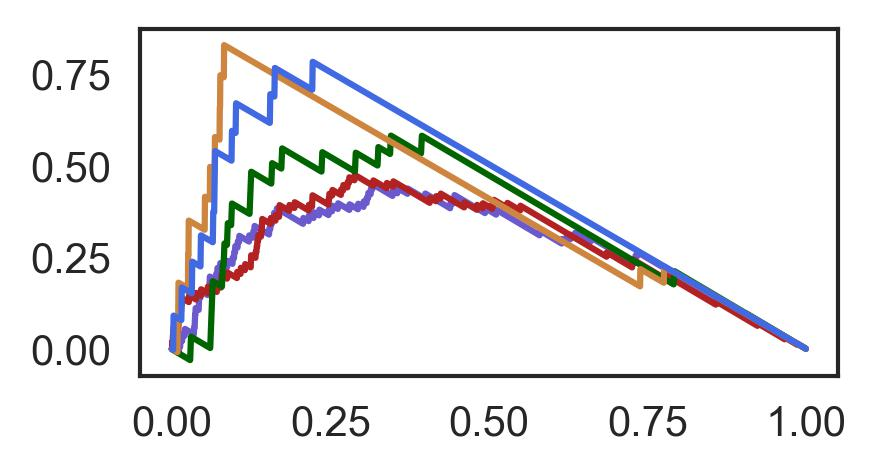

In [ ]:
fig,ax = plt.subplots(figsize=(3,1.5),dpi=300) 
sns.set_style('white')

for p in plot_term.keys():
    sns.lineplot(x=np.linspace(start=0,stop=1,num=len(all_go_results[p][plot_term[p]]['RES'])), y=all_go_results[p][plot_term[p]]['RES'],color=color_term[p],linewidth=1.5)


ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
ax.spines['top'].set_linewidth(1)
ax.spines['right'].set_linewidth(1)




64 2497
66 2636
18 759
12 2350
12 1391


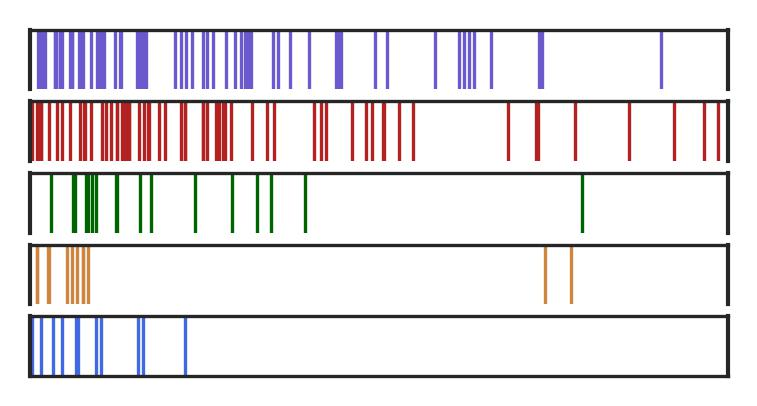

In [ ]:
fig,axs = plt.subplots(figsize=(3,1.5),dpi=300,ncols = 1, nrows = 5) 
sns.set_style('white')

for i in range(5):
    p = list(plot_term.keys())[i]
    hits = all_go_results[p][plot_term[p]]['hits']
    length = len(all_go_results[p][plot_term[p]]['RES'])
    print(len(hits),length)
    for h in hits:
        axs[i].axvline(x=h/length, color=color_term[p],linewidth=0.8)
    axs[i].spines['bottom'].set_linewidth(0)
    axs[i].spines['left'].set_linewidth(1)
    axs[i].spines['top'].set_linewidth(0.8)
    axs[i].spines['right'].set_linewidth(1)
    axs[i].set_yticks([])
    axs[i].set_xticks([])

    if i ==4:
        axs[i].spines['bottom'].set_linewidth(0.8)


## Spearmanr between -log10(pvalue) and LLPS score

In [ ]:
## Spearmanr between 

In [193]:
stats.spearmanr(all_bait_compare_summary_df['-log10(pv)'].tolist(),all_bait_compare_summary_df['SaPS'].tolist())

SignificanceResult(statistic=0.2782117524141834, pvalue=0.0005914839246766989)

d:\conda\Lib\site-packages\seaborn\distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'size'
  cset = contour_func(


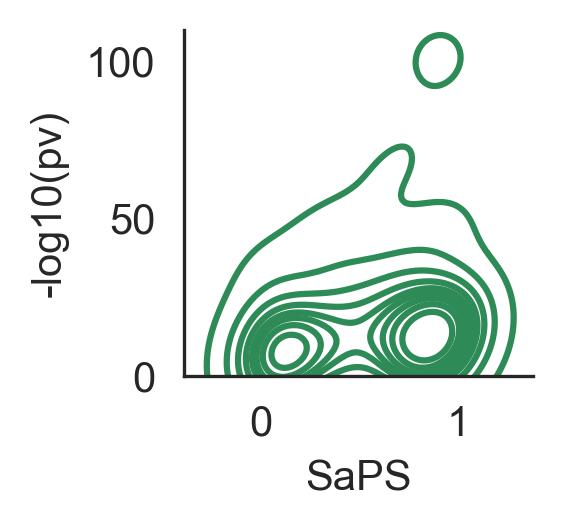

In [ ]:
fig = plt.subplots(figsize=(1.5,1.5),dpi=300) 
sns.set_style('white')

sns.kdeplot(data = all_bait_compare_summary_df,x='SaPS',y='-log10(pv)',color='seagreen',size=0.8)



sns.despine()

plt.ylim([0,110])

In [195]:
stats.spearmanr(all_bait_compare_summary_df['-log10(pv)'].tolist(),all_bait_compare_summary_df['PdPS'].tolist())

SignificanceResult(statistic=0.27538933011922273, pvalue=0.0006757905016461017)

d:\conda\Lib\site-packages\seaborn\distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'size'
  cset = contour_func(


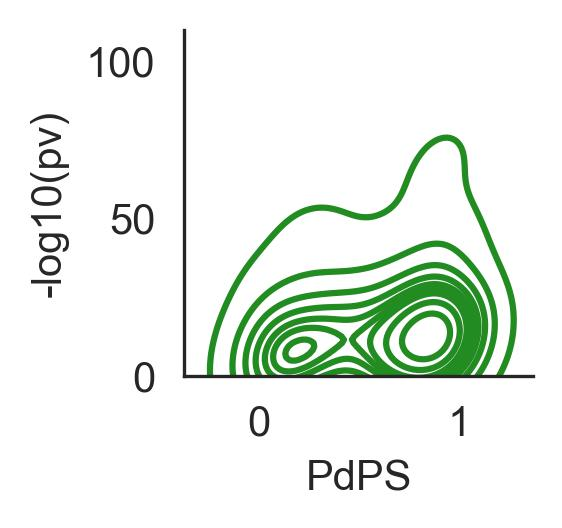

In [ ]:
fig = plt.subplots(figsize=(1.5,1.5),dpi=300) 
sns.set_style('white')

sns.kdeplot(data = all_bait_compare_summary_df,x='PdPS',y='-log10(pv)',color='forestgreen',size=0.8)



sns.despine()

plt.ylim([0,110])